In [1]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


# Noise analysis

In [266]:
df_noise = pd.read_csv('stagnant_long_test_00.csv')
df_noise['timediff'] = subtract_from_prev_val(df_noise, 'timestamp').fillna(0)

df_noise= df_noise[df_noise['gz'] > df_noise['gz'].mean() - 3*df_noise['gz'].std()]


(array([   14.,     0.,   652.,     0.,  1569.,     0.,   205.,     2.]),
 array([-17. , -16.5, -16. , -15.5, -15. , -14.5, -14. , -13.5, -13. ]),
 <a list of 8 Patch objects>)

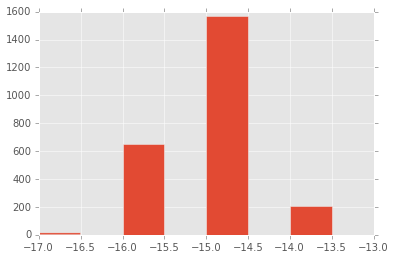

In [272]:
plt.hist(df_noise['gz'],bins=8)

In [281]:
# see the distribution, the mean and the std of the noise
noise_mean = df_noise['gz'].mean()
noise_var = np.var(df_noise['gz'])
# normally distributed

In [285]:
np.random.normal(noise_mean, noise_var, 2000)

array([-15.13376005, -15.27181016, -15.40306965, ..., -14.53375702,
       -15.08009546, -15.22868831])

The noise is normally distributed witha  mean of ~-15 and a variance of ~0.33.

To remove this noise from the signal, different signal techniques could be applied

# Basic Filter Design

In [432]:
df = pd.read_csv('stagnant_long_test_00.csv')
df['timediff'] = subtract_from_prev_val(df, 'timestamp').fillna(0)
# df['gz'] = scipy.signal.medfilt(df['gz'], kernel_size=3)
W = 10.0
h = [1/W]*int(W)
# np.convolve(df['gz'], h,'same' )
df['gz_smooth'] = np.convolve(df['gz'], h,'same')

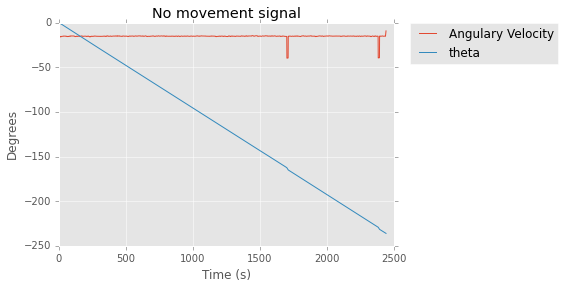

In [434]:
plt.plot(df['gz_smooth'] , label='Angulary Velocity')
plt.plot(integrate_col(df['timediff'] / 1000, df['gz_smooth']/16.4, 0), label='theta')
# there is obvious blipz in the system. How can we remove this? Outliers have major effects
plt.title('No movement signal')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Metric of interest: 
$$ MSE = \sum (\theta_{est} - \theta_{true})^2/ (n-1)$$

In [422]:
def metric(x, true):
    return np.sum(np.power(x - true,2)) / (len(x) - 1)

## Filter 1 - Additive Noise

$$ g(x) = f(x) - \mu_{noise} $$

0.79028247002518726

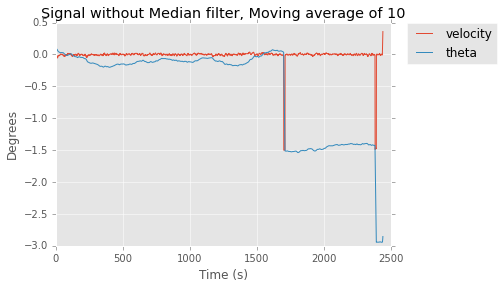

In [437]:
y = df['gz_smooth'] - noise_mean
theta =integrate_col( df['timediff'] / 1000, y/16.4, 0)
plt.plot(y/16.4, label='velocity')
plt.plot(theta, label='theta')
plt.title('Signal without Median filter, Moving average of 10')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
metric(theta,0)

# Filter 2 -  Kalman Filter

In [427]:
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=noise_mean, n_dim_obs=1, initial_state_covariance=[noise_var])

In [428]:
X = df['gz_smooth'].reshape((len(df),1))
print X.shape
Y = kf.em(X).smooth(X)
y = Y[0].reshape((len(df),)) - noise_mean
theta = integrate_col(df['timediff'] / 1000, y/16.4, 0)

(61, 1)


1272.9715759739672

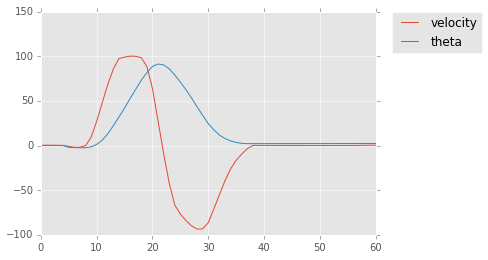

In [429]:
plt.plot(y/16.4, label='velocity')
plt.plot(theta, label='theta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
metric(theta, 0)


## Kalman Filter 2

In [425]:
sz = (len(df),) # size of array

# z = np.random.normal(noise_mean,noise_var,size=sz) # observations (normal about x, sigma=0.1)
z = df['gz_smooth']
Q = noise_var # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.array([noise_mean]*len(df))         # a posteri error estimate
xhatminus=np.array([noise_mean]*len(df)) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = noise_var # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,len(df)):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]
xhat = xhat - noise_mean
y = xhat
theta = integrate_col(df['timediff'] / 1000, y/16.4, 0)
metric(theta,0)

1288.7694451070488

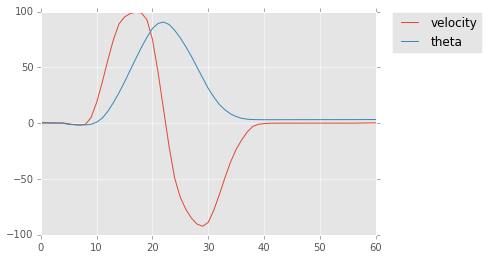

In [426]:
plt.plot(y/16.4, label='velocity')
plt.plot(theta, label='theta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)